In [50]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os, json, requests
from dateutil import tz
plt.rcParams['figure.figsize'] = [12, 16]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [27]:
longitude_methven = 171.670882
latitude_methven = -43.565537

longitude_lincoln = 172.4704
latitude_lincoln = -43.62622

In [28]:
def estimate_wetness(RH, rain):
    if (float(rain) > 0.05):
        return(1)
    elif (float(RH) >= 84.85):
        return(1)
    else:
        return(0)

In [29]:
def get_nasa_weather(longitude, latitude, start, end):
    #https://power.larc.nasa.gov/#resources for parameter codes, search in dropdown box
    base_url = r"https://power.larc.nasa.gov//api/temporal/hourly/point?parameters=T2M,RH2M,PRECTOTCORR&time-standard=UTC&community=SB&longitude={longitude}&latitude={latitude}&start={start}&end={end}&format=JSON"
    api_request_url = base_url.format(longitude=longitude, latitude=latitude, start=str(start), end=str(end))
    response = requests.get(url=api_request_url, verify=True, timeout=30.00)
    content = json.loads(response.content.decode('utf-8'))

    weather_df = pd.DataFrame(content['properties']['parameter'])

    weather_df['Date'] = pd.to_datetime(weather_df.index, format='%Y%m%d%H')
    weather_df = weather_df.reset_index(drop=True)
    
    weather_df.columns = (['Temp', 'RH', 'Rain', 'Date'])
    weather_df[['Temp', 'RH', 'Rain']] = weather_df[['Temp', 'RH', 'Rain']].apply(pd.to_numeric, args=('coerce',))
    weather_df['leaf_wetness'] = weather_df.apply(lambda x: estimate_wetness(x.RH, x.Rain), axis=1)
    
    weather_df['Date'] = weather_df['Date'].dt.tz_localize('UTC').dt.tz_convert('Pacific/Auckland') # to be correct, should probably get the time zone from the gps coords

    
    return(weather_df)

In [30]:
def get_niwa_weather(niwa_loc, start, end):
    temps = pd.read_csv(str(niwa_loc)+'_temps_hourly.csv', skiprows=8, skipfooter=8)[['Date(NZST)','Tmean(C)', 'RHmean(%)']]
    rain = pd.read_csv(str(niwa_loc)+'_rain_hourly.csv', skiprows=8, skipfooter=8)[['Date(NZST)','Amount(mm)']]
    df = temps.merge(rain, on='Date(NZST)')
    df.columns = (['Date', 'Temp', 'RH', 'Rain'])
    df[['Temp', 'RH', 'Rain']] = df[['Temp', 'RH', 'Rain']].apply(pd.to_numeric, args=('coerce',))
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d:%H%M')
    df['leaf_wetness'] = df.apply(lambda x: estimate_wetness(x.RH, x.Rain), axis=1)
    df = df.loc[(df['Date'] > pd.to_datetime(start, format='%Y%m%d')) & (df['Date'] <= pd.to_datetime(end, format='%Y%m%d'))]

    return(df)

In [31]:
def sporulation_metrics(df):
    df = df.set_index(pd.DatetimeIndex(df['Date']))
    daytime_temp = (1 if df.between_time('8:00','19:59')['Temp'].mean() < 24 else 0)
    nighttime_temp = (1 if (df.between_time('20:00','23:59')['Temp'].mean() < 24) & (df.between_time('20:00','23:59')['Temp'].mean() > 4) else 0)
    morning_temp = (1 if (df.between_time('00:00','04:59')['Temp'].max() < 24) & (df.between_time('00:00','04:59')['Temp'].min() > 4) else 0)
    morning_no_rain = (1 if (df.between_time('01:00','04:59')['Rain'].max() < 1) else 0)
    morning_high_RH = (0.5 if (df.between_time('01:00','04:59')['RH'].min() >= 90) else 0)
    morning_high_RH = (0.6 if (df.between_time('01:00','04:59')['RH'].min() >= 91) else morning_high_RH)
    morning_high_RH = (0.7 if (df.between_time('01:00','04:59')['RH'].min() >= 92) else morning_high_RH)
    morning_high_RH = (0.8 if (df.between_time('01:00','04:59')['RH'].min() >= 93) else morning_high_RH)
    morning_high_RH = (0.9 if (df.between_time('01:00','04:59')['RH'].min() >= 94) else morning_high_RH)
    morning_high_RH = (1 if (df.between_time('01:00','04:59')['RH'].min() >= 95) else 0)#morning_high_RH)
    morning_inf = (1 if df.between_time('4:00','07:59')['leaf_wetness'].sum() >= 2 else 0)
    evening_inf = (1 if df.between_time('19:00','23:59')['leaf_wetness'].sum() >= 1.5 else 0)
    return([daytime_temp, nighttime_temp, morning_temp, morning_no_rain, morning_high_RH, morning_inf, evening_inf])

In [32]:
def did_infection_ocour(df):
    df1 = pd.DataFrame(columns=['Date', 'inf_pos', 'spore_score_wi', 'spore_score_delay_inf_wi'])
    df1['Date'] = df['Date']
    df1['inf_pos'] = df['inf_total'].apply(lambda x: 1 if x > 0 else 0)
    df1['spore_score_wi'] = (df['spore_score']*df1['inf_pos'])
    df1['spore_score_wi'] = df1['spore_score_wi'].apply(lambda x: x-3 if x > 3.5 else 0)
    df1['spore_score_delay_inf_wi'] = df['spore_score_delay_inf']*df1['inf_pos']
    df1['spore_score_delay_inf_wi'] = df1['spore_score_delay_inf_wi'].apply(lambda x: x-3 if x > 3.5 else 0)
    return(df1)

In [33]:
def create_spores(df):
    spores = df.groupby(df['Date'].dt.date).apply(sporulation_metrics)
    spores = spores.to_frame(name='list_of_vars')
    spores[['daytime_temp','nighttime_temp','morning_temp','morning_no_rain','morning_high_RH', 'morning_inf','evening_inf']] = pd.DataFrame(spores.list_of_vars.tolist(), index= spores.index)
    spores = spores.drop('list_of_vars', axis=1)
    dtindx = pd.date_range(start = spores.index.min(), end = spores.index.max())
    spores = spores.reindex(dtindx, fill_value = np.nan)
    spores = spores.sort_index()
    spores['daytime_temp'] = spores['daytime_temp'].shift(1)
    spores['nighttime_temp'] = spores['nighttime_temp'].shift(1)
    spores['spore_score'] = spores[['daytime_temp','nighttime_temp','morning_temp','morning_no_rain','morning_high_RH']].sum(axis=1)
    spores['inf_total'] = spores[['morning_inf','evening_inf']].sum(axis=1)
    spores['spore_score_delay_inf'] = spores['spore_score'].shift(1)
    spores['Date'] = spores.index
    return(spores)




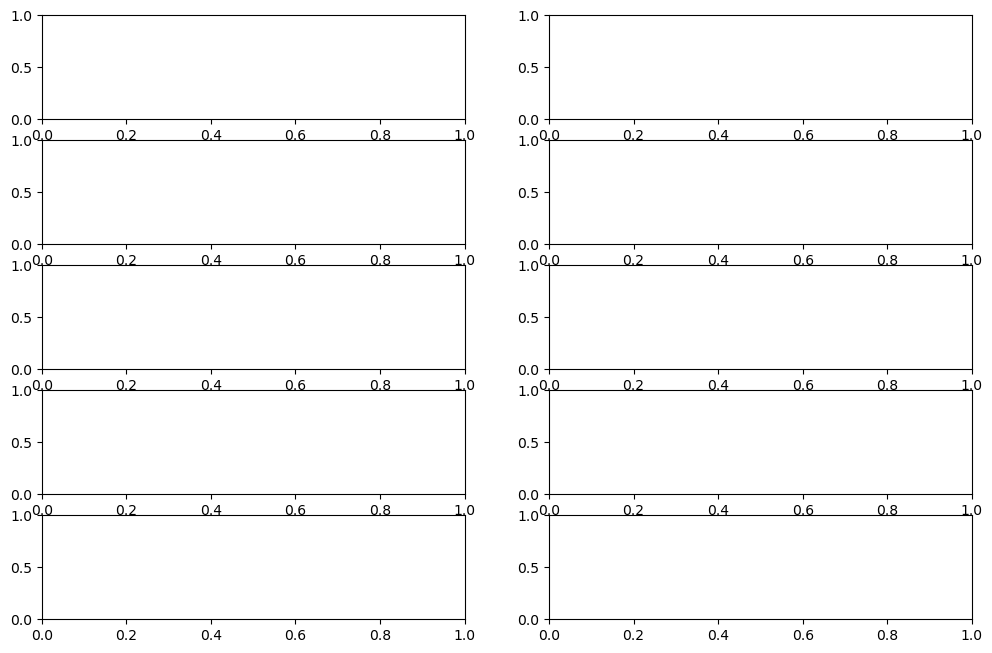

C:\Users\DaviesN\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
C:\Users\DaviesN\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
C:\Users\DaviesN\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
C:\Users\DaviesN\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falli

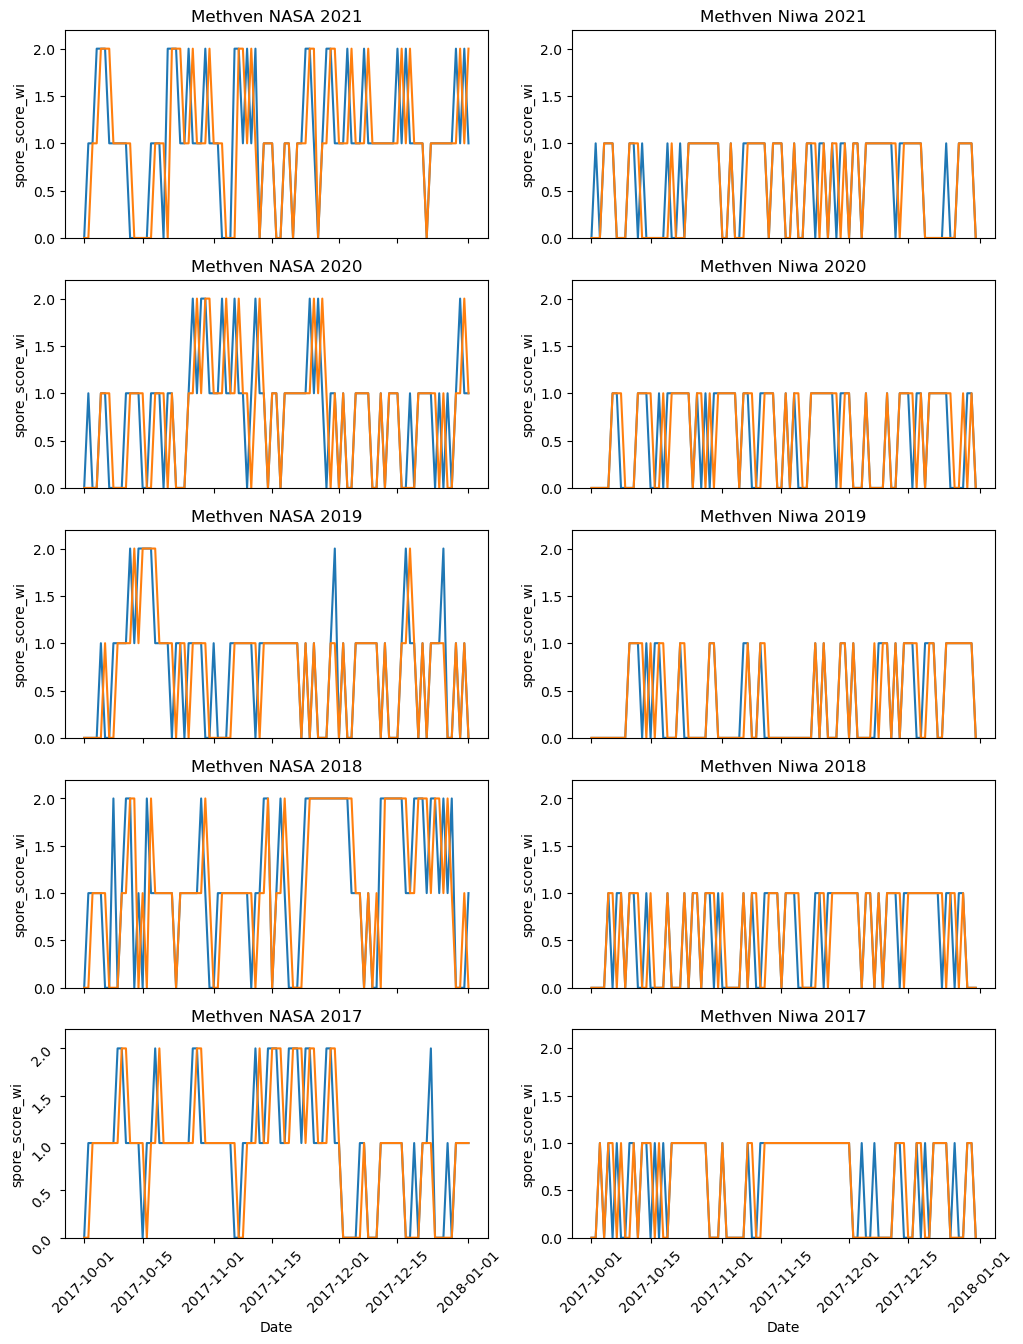

In [59]:
##############
# METHVEN DATA 
############
fig, axs = plt.subplots(ncols=2, nrows=5)

df = get_nasa_weather(longitude_methven, latitude_methven,  20211001, 20211231)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection, ax=axs[0,0]).set(title='Methven NASA 2021', ylim=(0, 2.2), xlabel=None, xticklabels=[])
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection, ax=axs[0,0]).set(xlabel=None)

df = get_niwa_weather('methven', 20211001, 20211231)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection, ax=axs[0,1]).set(title='Methven Niwa 2021', ylim=(0, 2.2), xlabel=None, xticklabels=[])
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection, ax=axs[0,1]).set(xlabel=None)

df = get_nasa_weather(longitude_methven, latitude_methven,  20201001, 20201231)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection, ax=axs[1,0]).set(title='Methven NASA 2020', ylim=(0, 2.2), xlabel=None, xticklabels=[])
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection, ax=axs[1,0]).set(xlabel=None)

df = get_niwa_weather('methven', 20201001, 20201231)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection, ax=axs[1,1]).set(title='Methven Niwa 2020', ylim=(0, 2.2), xlabel=None, xticklabels=[])
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection, ax=axs[1,1]).set(xlabel=None)

df = get_nasa_weather(longitude_methven, latitude_methven,  20191001, 20191231)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection, ax=axs[2,0]).set(title='Methven NASA 2019', ylim=(0, 2.2), xlabel=None, xticklabels=[])
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection, ax=axs[2,0]).set(xlabel=None)

df = get_niwa_weather('methven', 20191001, 20191231)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection, ax=axs[2,1]).set(title='Methven Niwa 2019', ylim=(0, 2.2), xlabel=None, xticklabels=[])
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection, ax=axs[2,1]).set(xlabel=None)

df = get_nasa_weather(longitude_methven, latitude_methven,  20181001, 20181231)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection, ax=axs[3,0]).set(title='Methven NASA 2018', ylim=(0, 2.2), xlabel=None, xticklabels=[])
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection, ax=axs[3,0]).set(xlabel=None)

df = get_niwa_weather('methven', 20181001, 20181231)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection, ax=axs[3,1]).set(title='Methven Niwa 2018', ylim=(0, 2.2), xlabel=None, xticklabels=[])
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection, ax=axs[3,1]).set(xlabel=None)
plt.xticks(rotation = 45)

df = get_nasa_weather(longitude_methven, latitude_methven,  20171001, 20171231)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection, ax=axs[4,0]).set(title='Methven NASA 2017', ylim=(0, 2.2))
plt.xticks(rotation = 45)
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection, ax=axs[4,0])
axs[4,0].tick_params(labelrotation=45)

df = get_niwa_weather('methven', 20171001, 20171231)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection, ax=axs[4,1]).set(title='Methven Niwa 2017', ylim=(0, 2.2))
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection, ax=axs[4,1])
plt.xticks(rotation = 45)

fig.savefig('downy_5_years_at_Marrs.png', facecolor='w', dpi=100)

C:\Users\DaviesN\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


(array([18901., 18915., 18932., 18946., 18962., 18976., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

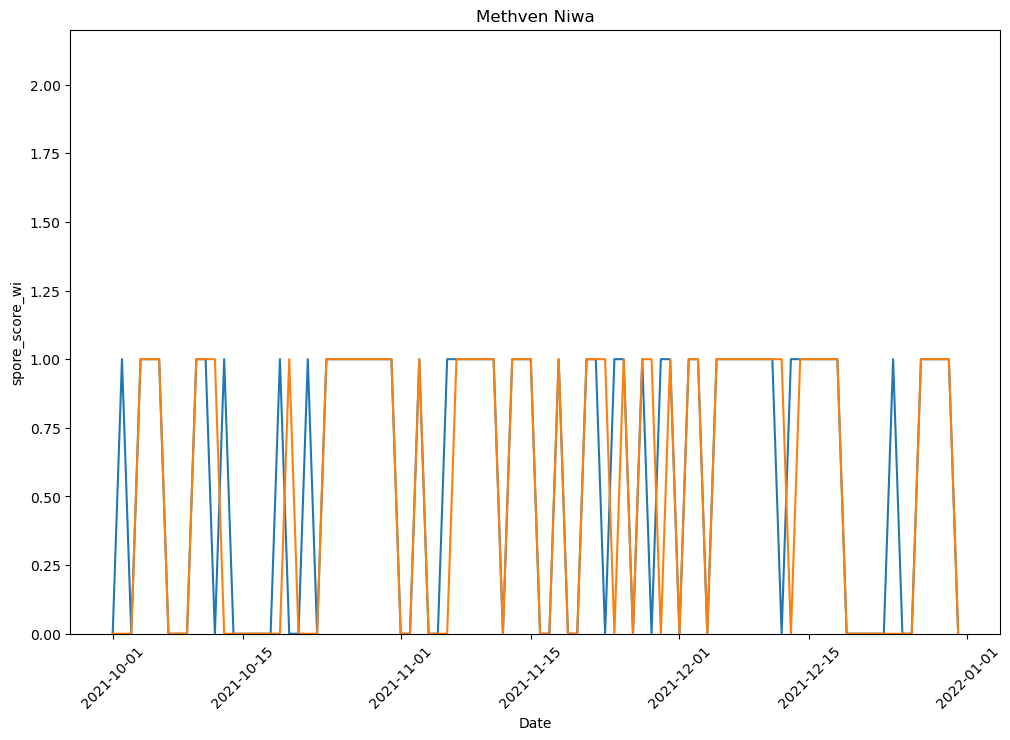

In [35]:
df = get_niwa_weather('methven', start, end)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection).set(title='Methven Niwa', ylim=(0, 2.2))
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection)
plt.xticks(rotation = 45)

(array([18946., 18953., 18962., 18969., 18976., 18983., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

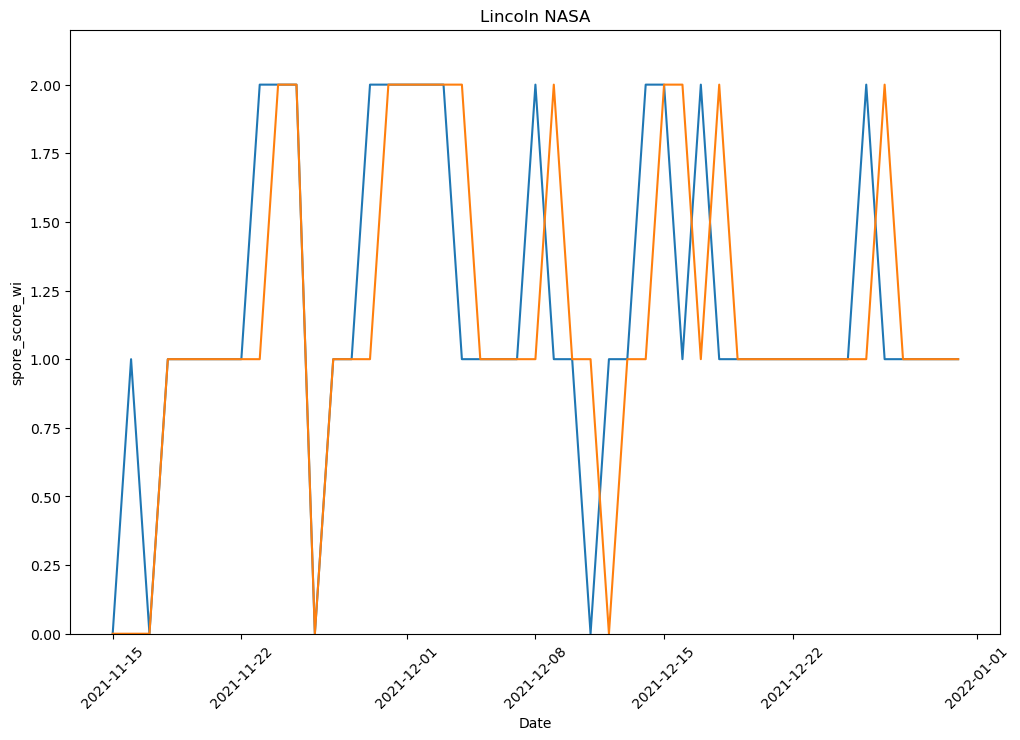

In [25]:
####################
# lincoln 
###################

df = get_nasa_weather(longitude_lincoln, latitude_lincoln, start, end)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection).set(title='Lincoln NASA', ylim=(0, 2.2))
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection)
plt.xticks(rotation = 45)


C:\Users\DaviesN\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


(array([18946., 18953., 18962., 18969., 18976., 18983., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

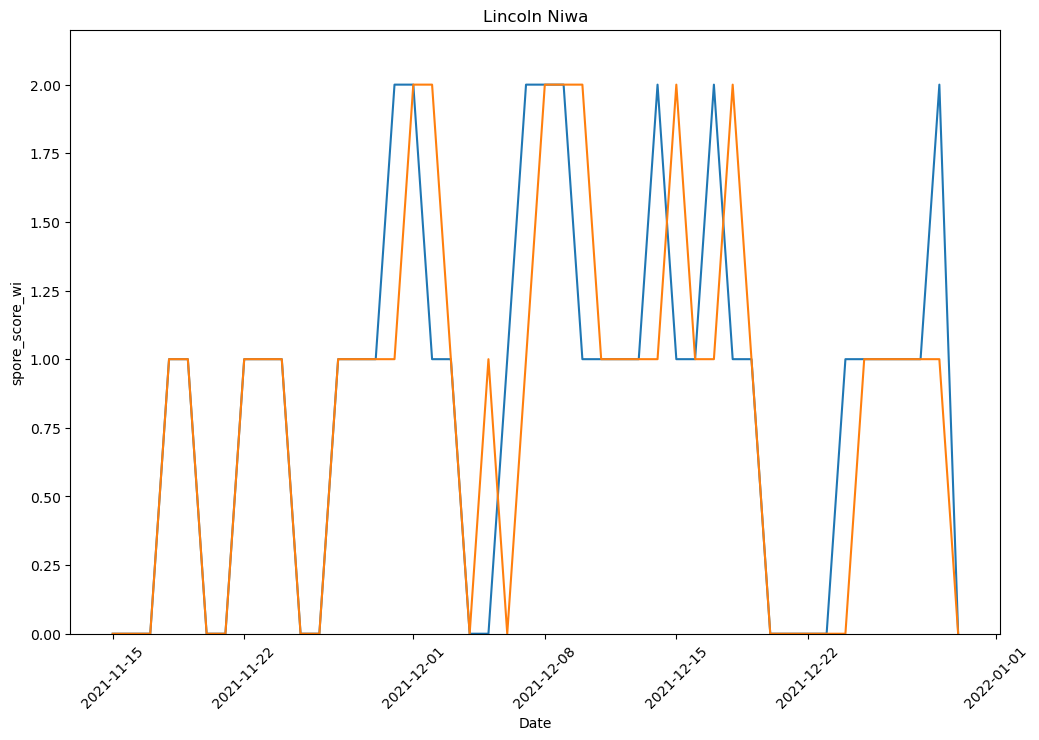

In [26]:
df = get_niwa_weather('lincoln', start, end)
spores = create_spores(df)
infection = did_infection_ocour(spores[['spore_score', 'inf_total', 'spore_score_delay_inf', 'Date']])

sb.lineplot(x='Date', y='spore_score_wi', data=infection).set(title='Lincoln Niwa', ylim=(0, 2.2))
sb.lineplot(x='Date', y='spore_score_delay_inf_wi', data=infection)
plt.xticks(rotation = 45)